# Problem Set 1 

In [1]:
%%capture
# Capture suppresses output to screen
import stata_setup
stata_setup.config("/Applications/Stata 17", "be")

In [2]:
%%stata
/* Define paths for data and output */
global data "Data"
global output "Output"


. /* Define paths for data and output */
. global data "Data"

. global output "Output"

. 


In [3]:
%%capture
%%stata
log using "$output/pd1.log", replace

## Start Data Prep

In [161]:
%%stata
use "$data/persico2004.dta", clear
describe


. use "$data/persico2004.dta", clear

. describe

Contains data from Data/persico2004.dta
 Observations:        12,686                  
    Variables:            50                  31 Dec 2018 19:16
-------------------------------------------------------------------------------
Variable      Storage   Display    Value
    name         type    format    label      Variable label
-------------------------------------------------------------------------------
VERSION_R2~2014 float   %9.0g                 VERSION_R26_1 2014
CASEID_1979     float   %9.0g                 ID# (1-12686) 79
FAM_1B_1979     float   %9.0g      vlR0000600
                                              AGE OF R 79
HGC_MOTHER_1979 float   %18.0g     vlR0006500
                                              HGC BY RS MOTHER 79
FAMOCC_19_1979  float   %32.0g     vlR0006900
                                              OCC OF LNGST JOB 78 STEP/MOTHERS
                                                3D 79
HGC_FATHER_19

Examine the gender breakdown in the original 1979 sample.

In [162]:
%%stata
tab SAMPLE_SEX_1979


SEX OF R 79 |      Freq.     Percent        Cum.
------------+-----------------------------------
       MALE |      6,403       50.47       50.47
     FEMALE |      6,283       49.53      100.00
------------+-----------------------------------
      Total |     12,686      100.00


Restrict the data to white males not in the poor supplemental group.

In [163]:
%%stata
codebook SAMPLE_RACE_78SCRN SAMPLE_SEX_1979 SAMPLE_ID_1979


-------------------------------------------------------------------------------
SAMPLE_RACE_78SCRN                                 RACL/ETHNIC COHORT /SCRNR 79
-------------------------------------------------------------------------------

                  Type: Numeric (float)
                 Label: vlR0214700

                 Range: [1,3]                         Units: 1
         Unique values: 3                         Missing .: 0/12,686

            Tabulation: Freq.   Numeric  Label
                        2,002         1  HISPANIC
                        3,174         2  BLACK
                        7,510         3  NON-BLACK, NON-HISPANIC

-------------------------------------------------------------------------------
SAMPLE_SEX_1979                                                     SEX OF R 79
-------------------------------------------------------------------------------

                  Type: Numeric (float)
                 Label: vlR0214800

                 Rang

In [164]:
%%stata
label list vlR0173600

vlR0173600:
           1 CROSS MALE WHITE
           2 CROSS MALE WH. POOR
           3 CROSS MALE BLACK
           4 CROSS MALE HISPANIC
           5 CROSS FEMALE WHITE
           6 CROSS FEMALE WH POOR
           7 CROSS FEMALE BLACK
           8 CROSS FEMALE HISPANIC
           9 SUP MALE WH POOR
          10 SUP MALE BLACK
          11 SUP MALE HISPANIC
          12 SUP FEM WH POOR
          13 SUP FEMALE BLACK
          14 SUP FEMALE HISPANIC
          15 MIL MALE WHITE
          16 MIL MALE BLACK
          17 MIL MALE HISPANIC
          18 MIL FEMALE WHITE
          19 MIL FEMALE BLACK
          20 MIL FEMALE HISPANIC


White, non-Hispanic respondents are coded as 3 in SAMPLE_RACE_78SCRN field.  
Male respondents are coded as 1 in the SAMPLE_SEX_1979 field.  
Poor white males are coded as 9 in the SAMPLE_ID_1979 field.

In [165]:
%%stata
keep if SAMPLE_RACE_78SCRN==3 & SAMPLE_SEX_1979==1 & SAMPLE_ID_1979 != 9

(9,638 observations deleted)


In [166]:
%%stata
count

  3,048


3,048 Observations remaining which matches the Persico, Postlewaite, and Silverman (2004) dataset.

Generate height81

In [167]:
%%stata
codebook HEALTH_HEIGHT_1981


-------------------------------------------------------------------------------
HEALTH_HEIGHT_1981                                               HEIGHT OF R 81
-------------------------------------------------------------------------------

                  Type: Numeric (float)
                 Label: vlR0481600, but 26 nonmissing values are not labeled

                 Range: [-5,609]                      Units: 1
         Unique values: 26                        Missing .: 0/3,048

              Examples: 508   
                        510   
                        511   
                        600   


Error coded values are less than 0.  The error values are replaced with 900 for parsing by the tostring command.  900 is easily detectable as no one is currently 9 ft tall.

In [168]:
%%stata
replace HEALTH_HEIGHT_1981=900 if HEALTH_HEIGHT_1981 < 0

(148 real changes made)


Transform integer values in strings for parsing.

In [169]:
%%stata
tostring HEALTH_HEIGHT_1981, generate(strHeight1981)

strHeight1981 generated as str3


In [170]:
%%stata
generate heightFt1981=substr(strHeight1981,1,1)
generate heightIn1981=substr(strHeight1981,2,3)
list heightFt1981 in 1/5
list heightIn1981 in 1/5


. generate heightFt1981=substr(strHeight1981,1,1)

. generate heightIn1981=substr(strHeight1981,2,3)

. list heightFt1981 in 1/5

     +----------+
     | he~t1981 |
     |----------|
  1. |        5 |
  2. |        5 |
  3. |        5 |
  4. |        5 |
  5. |        5 |
     +----------+

. list heightIn1981 in 1/5

     +----------+
     | he~n1981 |
     |----------|
  1. |       03 |
  2. |       04 |
  3. |       05 |
  4. |       06 |
  5. |       11 |
     +----------+

. 


Transform new inches and feet strings into integers and then combine in formula height1981 = 12*ft + inches

In [171]:
%%stata
destring heightFt1981, replace
destring heightIn1981, replace
generate height81= 12*heightFt1981 + heightIn1981
replace height81=. if HEALTH_HEIGHT_1981==900
label variable height81 "Height in inches. '.' is invalid."
summarize height81 if height81!=.


. destring heightFt1981, replace
heightFt1981: all characters numeric; replaced as byte

. destring heightIn1981, replace
heightIn1981: all characters numeric; replaced as byte

. generate height81= 12*heightFt1981 + heightIn1981

. replace height81=. if HEALTH_HEIGHT_1981==900
(148 real changes made, 148 to missing)

. label variable height81 "Height in inches. '.' is invalid."

. summarize height81 if height81!=.

    Variable |        Obs        Mean    Std. dev.       Min        Max
-------------+---------------------------------------------------------
    height81 |      2,900    70.34552    2.819987         55         81

. 


Error codes are less than 0.  The error observations are replaced by -1.  
Generate height85

In [172]:
%%stata
generate height85 = HEALTH_HEIGHT_1985
replace height85=. if height85<0
label variable height85 "Height in inches. '.' is invalid."
summarize height85 if height85!=.


. generate height85 = HEALTH_HEIGHT_1985

. replace height85=. if height85<0
(705 real changes made, 705 to missing)

. label variable height85 "Height in inches. '.' is invalid."

. summarize height85 if height85!=.

    Variable |        Obs        Mean    Std. dev.       Min        Max
-------------+---------------------------------------------------------
    height85 |      2,343     70.6402    2.778447         60         80

. 


Create a delta height for sample.

In [173]:
%%stata
generate deltaHeight = height85-height81
label variable deltaHeight "in inches. '.' is invalid"
summarize deltaHeight if deltaHeight!=.


. generate deltaHeight = height85-height81
(767 missing values generated)

. label variable deltaHeight "in inches. '.' is invalid"

. summarize deltaHeight if deltaHeight!=.

    Variable |        Obs        Mean    Std. dev.       Min        Max
-------------+---------------------------------------------------------
 deltaHeight |      2,281    .2889084    1.435852        -12         14

. 


Create age in 1996, age96.  
FAM_1B_1979 is the age of the respondents in 1979.  
Negative values are invalid response for various reasons.

In [174]:
%%stata
codebook FAM_1B_1979


-------------------------------------------------------------------------------
FAM_1B_1979                                                         AGE OF R 79
-------------------------------------------------------------------------------

                  Type: Numeric (float)
                 Label: vlR0000600, but 9 nonmissing values are not labeled

                 Range: [14,22]                       Units: 1
         Unique values: 9                         Missing .: 0/3,048

            Tabulation: Freq.   Numeric  Label
                          241        14  
                          340        15  
                          362        16  
                          320        17  
                          361        18  
                          419        19  
                          426        20  
                          434        21  
                          145        22  


In [175]:
%%stata
generate age96 = (1996 - 1979) + FAM_1B_1979
replace age96 =. if FAM_1B_1979 < 0
label variable age96 "R age in 1996"
summarize age96 if age > 0


. generate age96 = (1996 - 1979) + FAM_1B_1979

. replace age96 =. if FAM_1B_1979 < 0
(0 real changes made)

. label variable age96 "R age in 1996"

. summarize age96 if age > 0

    Variable |        Obs        Mean    Std. dev.       Min        Max
-------------+---------------------------------------------------------
       age96 |      3,048    35.04101    2.363981         31         39

. 


In [176]:
%stata summarize FAM_1B_1979


    Variable |        Obs        Mean    Std. dev.       Min        Max
-------------+---------------------------------------------------------
 FAM_1B_1979 |      3,048    18.04101    2.363981         14         22


Generate income, the reported income 1996.  
Invalid values are negative. Note: 0 is a valid response for this question.

## Income & Hours

In [177]:
%%stata
codebook Q13_5_TRUNC_REVISED_1996


-------------------------------------------------------------------------------
Q13_5_TRUNC_REVISED_1996                  AMT OF R'S WAGES/SALARY/TIPS (PCY) 96
-------------------------------------------------------------------------------

                  Type: Numeric (float)
                 Label: vlR5626201, but 304 nonmissing values are not labeled

                 Range: [-5,138775]                   Units: 1
         Unique values: 304                       Missing .: 0/3,048

              Examples: -5    
                        8000  
                        26000 
                        42000 


In [178]:
%%stata
generate income = Q13_5_TRUNC_REVISED_1996
replace income =. if Q13_5_TRUNC_REVISED_1996 < 0
label variable income "R income (USD) in 1996 Note: top 2% truncated. '.' is invalid"
summarize income if income !=.
hist income, percent


. generate income = Q13_5_TRUNC_REVISED_1996

. replace income =. if Q13_5_TRUNC_REVISED_1996 < 0
(954 real changes made, 954 to missing)

. label variable income "R income (USD) in 1996 Note: top 2% truncated. '.' is 
> invalid"

. summarize income if income !=.

    Variable |        Obs        Mean    Std. dev.       Min        Max
-------------+---------------------------------------------------------
      income |      2,094    34912.86    28871.08          0     138775

. hist income, percent
(bin=33, start=0, width=4205.303)

. 


Generate the variable hours, the number of hours worked in 1996.  
Invalid values are negative. Note: 0 is a valid response for this question.

In [179]:
%%stata
codebook HRSWK_PCY_1996
summarize HRSWK_PCY_1996 if HRSWK_PCY_1996 < 0 


. codebook HRSWK_PCY_1996

-------------------------------------------------------------------------------
HRSWK_PCY_1996                                       HRS WRKD IN PAST CAL YR 96
-------------------------------------------------------------------------------

                  Type: Numeric (float)
                 Label: vlR5167100, but 471 nonmissing values are not labeled

                 Range: [-5,6680]                     Units: 1
         Unique values: 471                       Missing .: 0/3,048

              Examples: -5    
                        1548  
                        2080  
                        2600  

. summarize HRSWK_PCY_1996 if HRSWK_PCY_1996 < 0 

    Variable |        Obs        Mean    Std. dev.       Min        Max
-------------+---------------------------------------------------------
HRSWK_P~1996 |        909   -4.969197    .2464227         -5         -3

. 


In [180]:
%%stata
generate hours = HRSWK_PCY_1996
replace hours =. if HRSWK_PCY_1996 < 0
label variable hours "Hours worked. '.' is invalid"
summarize hours if hours!=.


. generate hours = HRSWK_PCY_1996

. replace hours =. if HRSWK_PCY_1996 < 0
(909 real changes made, 909 to missing)

. label variable hours "Hours worked. '.' is invalid"

. summarize hours if hours!=.

    Variable |        Obs        Mean    Std. dev.       Min        Max
-------------+---------------------------------------------------------
       hours |      2,139    2222.443    918.1373          0       6680

. 


Generate fulltime variable.  
fulltime will be 1 if hours > 1,000.  Otherwise 0.

In [181]:
%%stata
generate fulltime=hours > 1000
replace fulltime=. if hours==.
label variable fulltime "1 if hours > 1000. '.' is invalid"
tab fulltime if fulltime!=.


. generate fulltime=hours > 1000

. replace fulltime=. if hours==.
(909 real changes made, 909 to missing)

. label variable fulltime "1 if hours > 1000. '.' is invalid"

. tab fulltime if fulltime!=.

 1 if hours |
> 1000. '.' |
 is invalid |      Freq.     Percent        Cum.
------------+-----------------------------------
          0 |        213        9.96        9.96
          1 |      1,926       90.04      100.00
------------+-----------------------------------
      Total |      2,139      100.00

. 


Generate ln(wages).  Stata will generate '.' (missing value) for ln(0)

In [182]:
%%stata
generate lnWage=ln(income/hours)
replace lnWage=. if income==. | hours==.
label variable lnWage "Ln of income/hours"
summarize lnWage if lnWage!=.


. generate lnWage=ln(income/hours)
(1,140 missing values generated)

. replace lnWage=. if income==. | hours==.
(0 real changes made)

. label variable lnWage "Ln of income/hours"

. summarize lnWage if lnWage!=.

    Variable |        Obs        Mean    Std. dev.       Min        Max
-------------+---------------------------------------------------------
      lnWage |      1,908    2.605704    .6915462  -2.091864   6.620073

. 


Generate basicOLS == 1 if lnWage, height81, height95, age96 are all present.

In [183]:
%%stata
generate basicOLS=(lnWage!=. & /// 
                   height81!=. & ///
                   height85!=. & ///
                   age96!=.)
label variable basicOLS "lnWage, height81, height85, age96 are all valid"
tab basicOLS


. generate basicOLS=(lnWage!=. & /// 
>                    height81!=. & ///
>                    height85!=. & ///
>                    age96!=.)

. label variable basicOLS "lnWage, height81, height85, age96 are all valid"

. tab basicOLS

    lnWage, |
  height81, |
  height85, |
  age96 are |
  all valid |      Freq.     Percent        Cum.
------------+-----------------------------------
          0 |      1,230       40.35       40.35
          1 |      1,818       59.65      100.00
------------+-----------------------------------
      Total |      3,048      100.00

. 


Generate educ.  This is the highest level of education 
    reported from the 1979,1988, 1994, and 1996 surveys.

In [184]:
%%stata
codebook Q3_4_*


-------------------------------------------------------------------------------
Q3_4_1979                                                                HGC 79
-------------------------------------------------------------------------------

                  Type: Numeric (float)
                 Label: vlR0017300, but 1 nonmissing value is not labeled

                 Range: [-3,16]                       Units: 1
         Unique values: 14                        Missing .: 0/3,048

              Examples: 9     9TH GRADE
                        10    10TH GRADE
                        12    12TH GRADE
                        12    12TH GRADE

-------------------------------------------------------------------------------
Q3_4_1981                                                                HGC 81
-------------------------------------------------------------------------------

                  Type: Numeric (float)
                 Label: vlR0417400, but 2 nonmissing values are n

In [185]:
%%stata
label list vlR0017300 vlR0417400 vlR1605100 vlR5221800

vlR0017300:
           0 NONE
           1 1ST GRADE
           2 2ND GRADE
           3 3RD GRADE
           4 4TH GRADE
           5 5TH GRADE
           6 6TH GRADE
           7 7TH GRADE
           8 8TH GRADE
           9 9TH GRADE
          10 10TH GRADE
          11 11TH GRADE
          12 12TH GRADE
          13 1ST YR COL
          14 2ND YR COL
          15 3RD YR COL
          16 4TH YR COL
          17 5TH YR COL
          18 6TH YR COL
          19 7TH YR COL
          20 8TH YR COL OR MORE
          95 UNGRADED
vlR0417400:
           0 NONE
           1 1ST GRADE
           2 2ND GRADE
           3 3RD GRADE
           4 4TH GRADE
           5 5TH GRADE
           6 6TH GRADE
           7 7TH GRADE
           8 8TH GRADE
           9 9TH GRADE
          10 10TH GRADE
          11 11TH GRADE
          12 12TH GRADE
          13 1ST YR COL
          14 2ND YR COL
          15 3RD YR COL
          16 4TH YR COL
          17 5TH YR COL
          18 6TH YR COL
          19 7TH

95 is ungraded.  This will be replaces by 0 so rowmax does not capture this as the highest grade.

In [186]:
%%stata
foreach n of numlist 1979 1981 1985 1996 {
    generate Q3_4_`n'_norm = Q3_4_`n'
    replace Q3_4_`n'_norm = 0 if Q3_4_`n'_norm ==95
}
summarize Q3_4_*_norm


. foreach n of numlist 1979 1981 1985 1996 {
  2.     generate Q3_4_`n'_norm = Q3_4_`n'
  3.     replace Q3_4_`n'_norm = 0 if Q3_4_`n'_norm ==95
  4. }
(0 real changes made)
(1 real change made)
(1 real change made)
(0 real changes made)

. summarize Q3_4_*_norm

    Variable |        Obs        Mean    Std. dev.       Min        Max
-------------+---------------------------------------------------------
Q3_4_1979_~m |      3,048    10.52329    2.327639         -3         16
Q3_4_1981_~m |      3,048    3.973425    8.052316         -5         18
Q3_4_1985_~m |      3,048   -.5442913    7.568742         -5         20
Q3_4_1996_~m |      3,048    -3.24147    4.494108         -5         20

. 


In [187]:
%%stata
egen educ=rowmax(Q3_4_*_norm)
replace educ=. if educ<0
summarize educ


. egen educ=rowmax(Q3_4_*_norm)

. replace educ=. if educ<0
(6 real changes made, 6 to missing)

. summarize educ

    Variable |        Obs        Mean    Std. dev.       Min        Max
-------------+---------------------------------------------------------
        educ |      3,042    12.23176    2.239346          5         20

. 


(bin=34, start=5, width=.44117647)


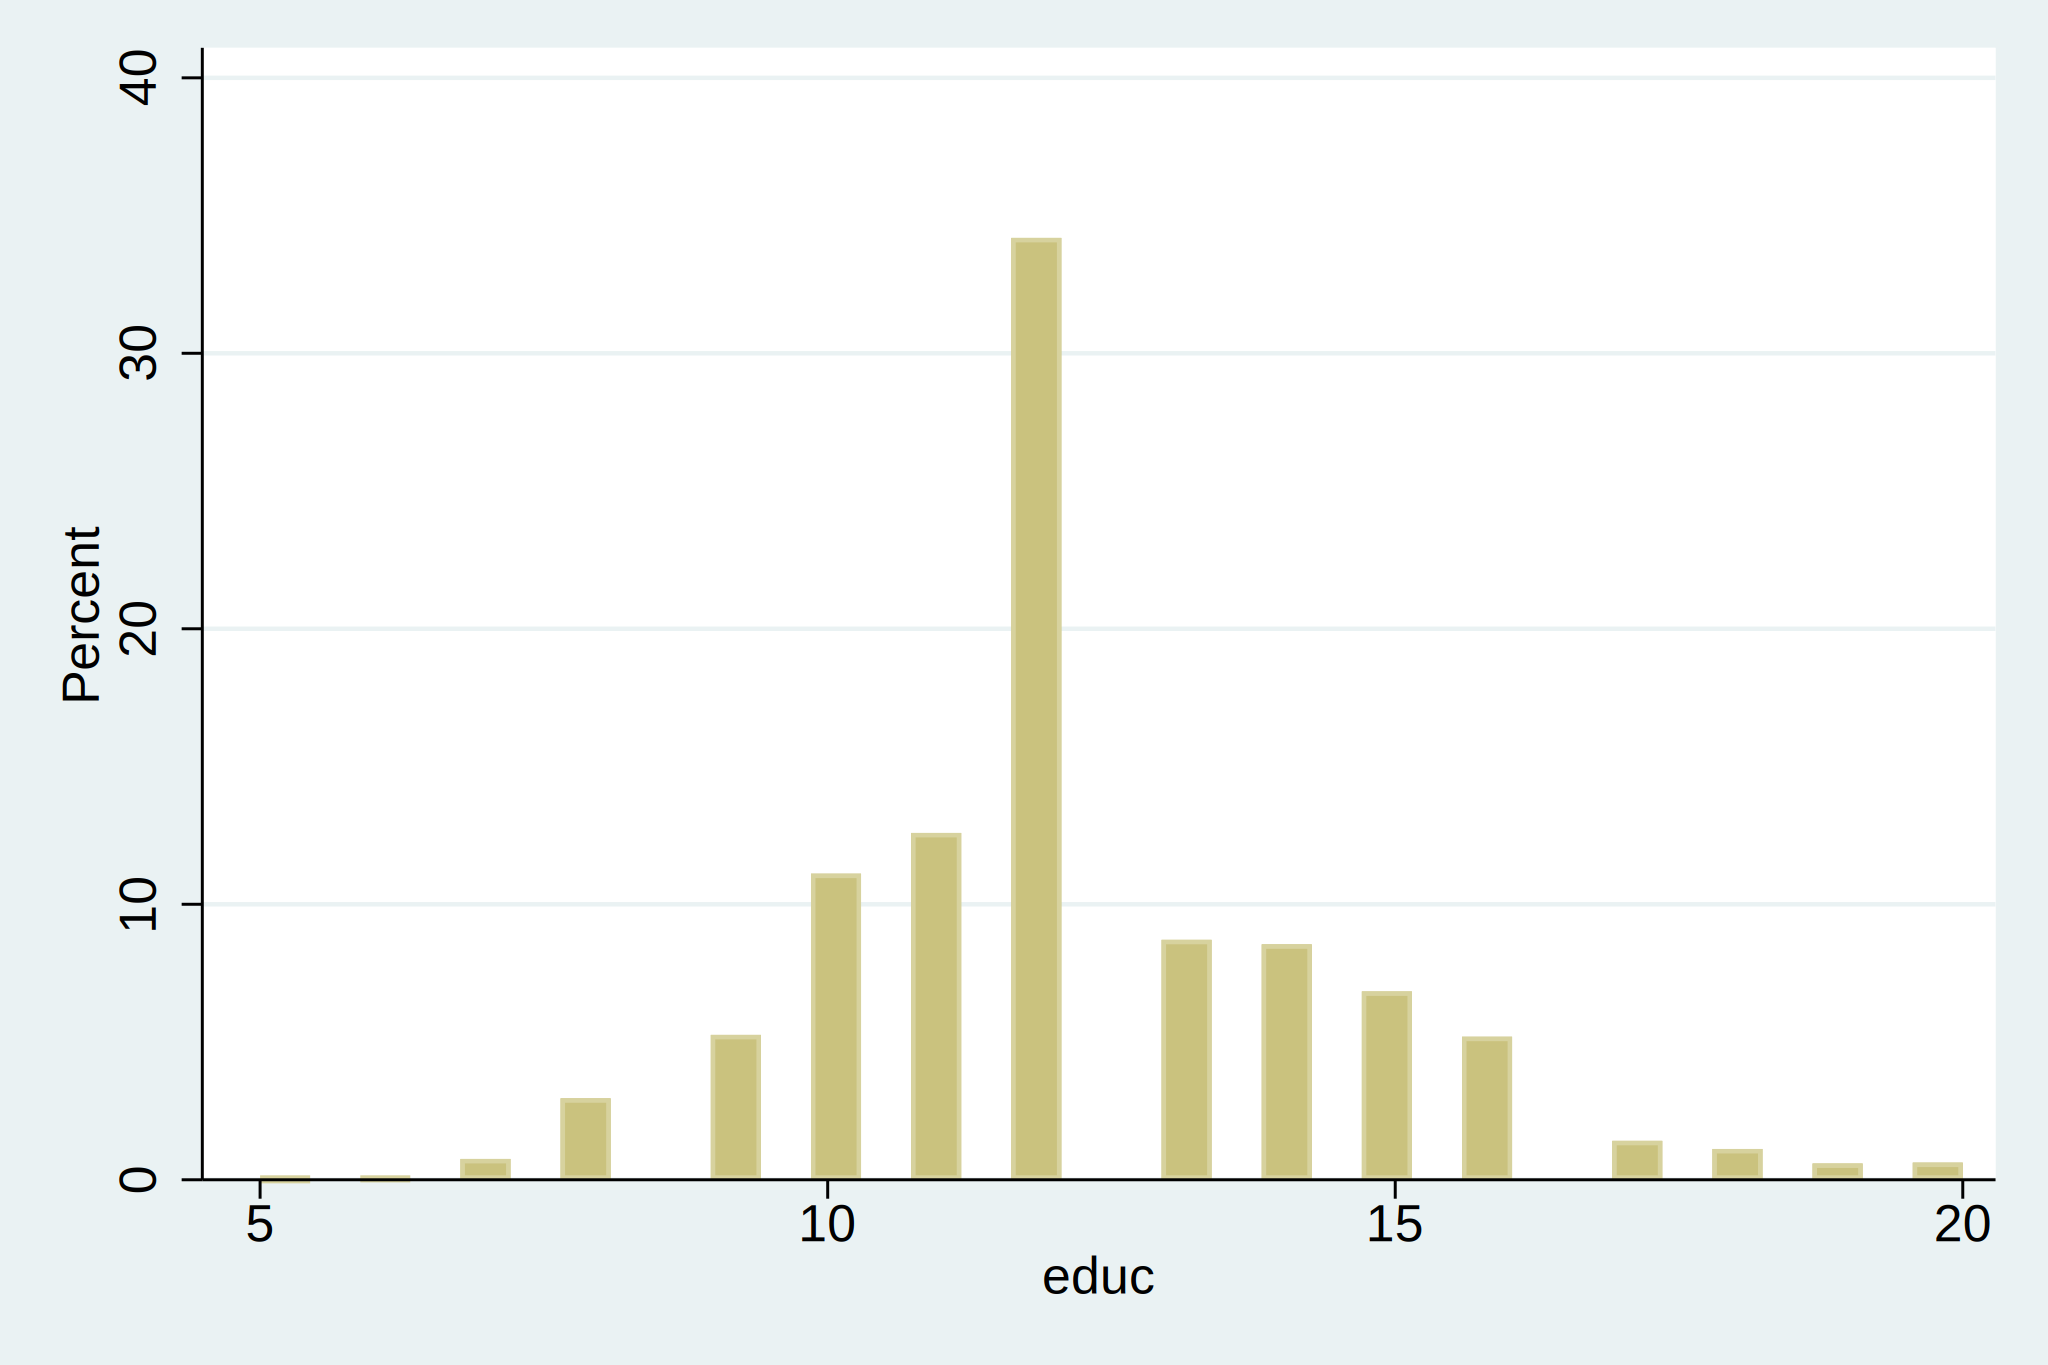

In [188]:
%%stata
histogram educ, percent

Create variable evermarried.  Will be 1 if the person was ever married between 1979-1994.  

In [189]:
%%stata
codebook MARSTAT_KEY_*


-------------------------------------------------------------------------------
MARSTAT_KEY_1979                                              MARITAL STATUS 79
-------------------------------------------------------------------------------

                  Type: Numeric (float)
                 Label: vlR0217501, but 1 nonmissing value is not labeled

                 Range: [-3,3]                        Units: 1
         Unique values: 5                         Missing .: 0/3,048

            Tabulation: Freq.   Numeric  Label
                            1        -3  
                        2,768         0  NEVER MARRIED
                          262         1  MARRIED
                            9         2  SEPARATED
                            8         3  DIVORCED

-------------------------------------------------------------------------------
MARSTAT_KEY_1980                                              MARITAL STATUS 80
-------------------------------------------------------

                          821        -5  
                            1        -3  
                          707         0  NEVER MARRIED
                        1,273         1  MARRIED
                           59         2  SEPARATED
                          186         3  DIVORCED
                            1         6  WIDOWED

-------------------------------------------------------------------------------
MARSTAT_KEY_1991                                              MARITAL STATUS 91
-------------------------------------------------------------------------------

                  Type: Numeric (float)
                 Label: vlR3656800, but 1 nonmissing value is not labeled

                 Range: [-5,6]                        Units: 1
         Unique values: 6                         Missing .: 0/3,048

            Tabulation: Freq.   Numeric  Label
                          793        -5  
                          651         0  NEVER MARRIED
                        1,34

Values less than 0 are error codes.  Values 1 or higher indicated the respondent is currently or was previously married and is now either separated, divorced or widowed.

In [190]:
%%stata
/* 
Find highest value for married.  Once respondent is above 0 then they
    are considered have been married.
*/
egen everMarried =rowmax(MARSTAT_KEY_*)

// Replace error codes with Stata missing value indicator
replace everMarried=. if everMarried < 0

// Set everMarried parameter to 1 if person was ever married.
replace everMarried=(everMarried>0)

tab everMarried


. /* 
> Find highest value for married.  Once respondent is above 0 then they
>     are considered have been married.
> */
. egen everMarried =rowmax(MARSTAT_KEY_*)

. 
. // Replace error codes with Stata missing value indicator
. replace everMarried=. if everMarried < 0
(0 real changes made)

. 
. // Set everMarried parameter to 1 if person was ever married.
. replace everMarried=(everMarried>0)
(845 real changes made)

. 
. tab everMarried

everMarried |      Freq.     Percent        Cum.
------------+-----------------------------------
          0 |        656       21.52       21.52
          1 |      2,392       78.48      100.00
------------+-----------------------------------
      Total |      3,048      100.00

. 


Create momSchool. This is the highest grade of mother's years of schooling in 1979.

In [191]:
%%stata
codebook HGC_MOTHER_1979
label list vlR0006500
summarize HGC_MOTHER_1979


. codebook HGC_MOTHER_1979

-------------------------------------------------------------------------------
HGC_MOTHER_1979                                             HGC BY RS MOTHER 79
-------------------------------------------------------------------------------

                  Type: Numeric (float)
                 Label: vlR0006500, but 3 nonmissing values are not labeled

                 Range: [-4,20]                       Units: 1
         Unique values: 22                        Missing .: 0/3,048

              Examples: 10    10TH GRADE
                        12    12TH GRADE
                        12    12TH GRADE
                        13    1ST YR COL

. label list vlR0006500
vlR0006500:
           0 NONE
           1 1ST GRADE
           2 2ND GRADE
           3 3RD GRADE
           4 4TH GRADE
           5 5TH GRADE
           6 6TH GRADE
           7 7TH GRADE
           8 8TH GRADE
           9 9TH GRADE
          10 10TH GRADE
          11 11TH GRADE
      

In [192]:
%%stata
generate momSchool=HGC_MOTHER_1979
replace momSchool=. if HGC_MOTHER_1979<0
summarize momSchool


. generate momSchool=HGC_MOTHER_1979

. replace momSchool=. if HGC_MOTHER_1979<0
(138 real changes made, 138 to missing)

. summarize momSchool

    Variable |        Obs        Mean    Std. dev.       Min        Max
-------------+---------------------------------------------------------
   momSchool |      2,910    11.94845    2.359148          0         20

. 


Generate momSkilled.  This will be 1 if the mother's occupation code is classified as professional/managerial.

In [193]:
%%stata
codebook FAMOCC_19_1979
label list vlR0006900


. codebook FAMOCC_19_1979

-------------------------------------------------------------------------------
FAMOCC_19_1979                           OCC OF LNGST JOB 78 STEP/MOTHERS 3D 79
-------------------------------------------------------------------------------

                  Type: Numeric (float)
                 Label: vlR0006900, but 193 nonmissing values are not labeled

                 Range: [-4,984]                      Units: 1
         Unique values: 193                       Missing .: 0/3,048

              Examples: -4    
                        -3    
                        310   
                        621   

. label list vlR0006900
vlR0006900:
           0 0: 00      NONE
         990 990: 990     SAME AS PRESENT JOB
         995 995: 995     DID NOT WORK
         996 996: 996     NEVER WORKED

. 


In [194]:
%%stata
summarize FAMOCC_19_1979 if FAMOCC_19_1979 < 0


    Variable |        Obs        Mean    Std. dev.       Min        Max
-------------+---------------------------------------------------------
FAMOCC_19_~9 |      1,257   -3.932379    .3055383         -4         -1


Codes 1-245 are considered professional/managerial. Negative values are error codes.

In [195]:
%%stata
generate momSkilled = FAMOCC_19_1979
replace momSkilled=. if FAMOCC_19_1979 < 0
replace momSkilled= 1 if (momSkilled <= 245 & momSkilled!=.)
replace momSkilled= 0 if (momSkilled > 245 & momSkilled!=.)
tab momSkilled


. generate momSkilled = FAMOCC_19_1979

. replace momSkilled=. if FAMOCC_19_1979 < 0
(1,257 real changes made, 1,257 to missing)

. replace momSkilled= 1 if (momSkilled <= 245 & momSkilled!=.)
(339 real changes made)

. replace momSkilled= 0 if (momSkilled > 245 & momSkilled!=.)
(1,438 real changes made)

. tab momSkilled

 momSkilled |      Freq.     Percent        Cum.
------------+-----------------------------------
          0 |      1,438       80.29       80.29
          1 |        353       19.71      100.00
------------+-----------------------------------
      Total |      1,791      100.00

. 


Create dadSchool and dadSkilled. Job codes 1-245 are considered professional/managerial.

In [196]:
%%stata
codebook HGC_FATHER_1979 FAMOCC_26_1979


-------------------------------------------------------------------------------
HGC_FATHER_1979                                             HGC BY RS FATHER 79
-------------------------------------------------------------------------------

                  Type: Numeric (float)
                 Label: vlR0007900, but 3 nonmissing values are not labeled

                 Range: [-4,20]                       Units: 1
         Unique values: 24                        Missing .: 0/3,048

              Examples: 9     9TH GRADE
                        12    12TH GRADE
                        12    12TH GRADE
                        15    3RD YR COL

-------------------------------------------------------------------------------
FAMOCC_26_1979                           OCC OF LNGST JOB 78 STEP/FATHERS 3D 79
-------------------------------------------------------------------------------

                  Type: Numeric (float)
                 Label: vlR0008300, but 267 nonmissing values a

In [197]:
%%stata
// Dad's education level
generate dadSchool=HGC_FATHER_1979
replace dadSchool=. if HGC_FATHER_1979<0
summarize dadSchool

// Create dummy indicating whether dad is a skilled worker
generate dadSkilled = FAMOCC_26_1979  
replace dadSkilled=. if FAMOCC_26_1979   < 0
replace dadSkilled= 1 if (dadSkilled <= 245 & dadSkilled!=.)
replace dadSkilled= 0 if (dadSkilled > 245 & dadSkilled!=.)
tab dadSkilled


. // Dad's education level
. generate dadSchool=HGC_FATHER_1979

. replace dadSchool=. if HGC_FATHER_1979<0
(210 real changes made, 210 to missing)

. summarize dadSchool

    Variable |        Obs        Mean    Std. dev.       Min        Max
-------------+---------------------------------------------------------
   dadSchool |      2,838    12.21318    3.319548          0         20

. 
. // Create dummy indicating whether dad is a skilled worker
. generate dadSkilled = FAMOCC_26_1979  

. replace dadSkilled=. if FAMOCC_26_1979   < 0
(527 real changes made, 527 to missing)

. replace dadSkilled= 1 if (dadSkilled <= 245 & dadSkilled!=.)
(785 real changes made)

. replace dadSkilled= 0 if (dadSkilled > 245 & dadSkilled!=.)
(1,709 real changes made)

. tab dadSkilled

 dadSkilled |      Freq.     Percent        Cum.
------------+-----------------------------------
          0 |      1,709       67.79       67.79
          1 |        812       32.21      100.00
------------+------------

Create siblings which is equal to FAM_28A_1979. Negative values indicate invalid/lack of responses.

In [198]:
%%stata
codebook FAM_28A_1979
generate siblings=FAM_28A_1979
replace siblings=. if siblings<0
summarize siblings


. codebook FAM_28A_1979

-------------------------------------------------------------------------------
FAM_28A_1979                                                       # OF SIBS 79
-------------------------------------------------------------------------------

                  Type: Numeric (float)
                 Label: vlR0009100, but 18 nonmissing values are not labeled

                 Range: [0,17]                        Units: 1
         Unique values: 18                        Missing .: 0/3,048

              Examples: 1     
                        2     
                        3     
                        4     

. generate siblings=FAM_28A_1979

. replace siblings=. if siblings<0
(0 real changes made)

. summarize siblings

    Variable |        Obs        Mean    Std. dev.       Min        Max
-------------+---------------------------------------------------------
    siblings |      3,048    3.083005    2.055674          0         17

. 


Generate finalSample variable.  This indicates that on the necessary observations are available in the data.

In [199]:
%%stata
generate finalSample=(height81!=. & height85!=. & age96!=. & ///
                     momSchool!=. & momSkilled!=. & ///
                     dadSchool!=. & dadSkilled!=. & ///
                     siblings!=. & lnWage !=.)
tab finalSample


. generate finalSample=(height81!=. & height85!=. & age96!=. & ///
>                      momSchool!=. & momSkilled!=. & ///
>                      dadSchool!=. & dadSkilled!=. & ///
>                      siblings!=. & lnWage !=.)

. tab finalSample

finalSample |      Freq.     Percent        Cum.
------------+-----------------------------------
          0 |      2,158       70.80       70.80
          1 |        890       29.20      100.00
------------+-----------------------------------
      Total |      3,048      100.00

. 


In [200]:
%%stata
// Create macro for family characteristics
global family "age96 momSchool momSkilled dadSchool dadSkilled siblings everMarried"
summarize $family


. // Create macro for family characteristics
. global family "age96 momSchool momSkilled dadSchool dadSkilled siblings everM
> arried"

. summarize $family

    Variable |        Obs        Mean    Std. dev.       Min        Max
-------------+---------------------------------------------------------
       age96 |      3,048    35.04101    2.363981         31         39
   momSchool |      2,910    11.94845    2.359148          0         20
  momSkilled |      1,791    .1970966     .397917          0          1
   dadSchool |      2,838    12.21318    3.319548          0         20
  dadSkilled |      2,521    .3220944    .4673716          0          1
-------------+---------------------------------------------------------
    siblings |      3,048    3.083005    2.055674          0         17
 everMarried |      3,048    .7847769    .4110445          0          1

. 


In [218]:
%%stata
global adjX "momSchool momSkilled dadSchool dadSkilled siblings"
global criteria "finalSample==1 & fulltime==1"


. global adjX "momSchool momSkilled dadSchool dadSkilled siblings"

. global criteria "finalSample==1 & fulltime==1"

. 


Generate modified Table 1 for unrestricted sample and finalSample ==1

In [201]:
%%stata
// Unrestricted sample
tabstat height81 height85 deltaHeight, statistics(mean q n sd) 

// Restricted to finalSample == 1
tabstat height81 height85 deltaHeight if finalSample==1, statistics(mean q n sd) 


. // Unrestricted sample
. tabstat height81 height85 deltaHeight, statistics(mean q n sd) 

   Stats |  height81  height85  deltaH~t
---------+------------------------------
    Mean |  70.34552   70.6402  .2889084
     p25 |        69        69         0
     p50 |        71        71         0
     p75 |        72        72         1
       N |      2900      2343      2281
      SD |  2.819987  2.778447  1.435852
----------------------------------------

. 
. // Restricted to finalSample == 1
. tabstat height81 height85 deltaHeight if finalSample==1, statistics(mean q n 
> sd) 

   Stats |  height81  height85  deltaH~t
---------+------------------------------
    Mean |  70.34831  70.72472  .3764045
     p25 |        69        69         0
     p50 |        71        71         0
     p75 |        72        72         1
       N |       890       890       890
      SD |  2.897581  2.737392  1.485174
----------------------------------------

. 


Generate Modified table 2 that displays characteristics by above/below median height.

In [202]:
%%stata
// Generate aboveMedian
generate aboveMedian=(height85>71)


. // Generate aboveMedian
. generate aboveMedian=(height85>71)

. 


In [225]:
%%stata
// Generate information for the table
tabstat height81 height85 lnWage $family if $criteria, /// 
    by(aboveMedian) statistics(mean sd n)


. // Generate information for the table
. tabstat height81 height85 lnWage $family if $criteria, /// 
>     by(aboveMedian) statistics(mean sd n)

Summary statistics: Mean, SD, N
Group variable: aboveMedian 

aboveMedian |  height81  height85    lnWage     age96  momSch~l  momSki~d
------------+------------------------------------------------------------
          0 |  68.59792   68.8125  2.613508   34.4375  12.26042     .1875
            |  2.306113  2.041902  .6007802  2.238459  2.455639  .3907196
            |       480       480       480       480       480       480
------------+------------------------------------------------------------
          1 |  72.51842  73.09474  2.711577  34.48421  12.49474  .2157895
            |  1.917061  1.269273  .6102725  2.319417  2.094716  .4119113
            |       380       380       380       380       380       380
------------+------------------------------------------------------------
      Total |  70.33023  70.70465  2.656841  34.45

In [224]:
%%stata
quietly foreach var of varlist height81 height85 lnWage $family{ 
    regress `var' i.aboveMedian if $criteria, robust
    eststo `var'Diff
}
esttab height81Diff height85Diff age96Diff lnWageDiff, ///
    keep(1.aboveMedian) se
    
esttab everMarriedDiff momSchoolDiff momSkilledDiff, ///
    keep(1.aboveMedian) se

esttab dadSchoolDiff dadSkilledDiff, ///
    keep(1.aboveMedian) se


. quietly foreach var of varlist height81 height85 lnWage $family{ 

. esttab height81Diff height85Diff age96Diff lnWageDiff, ///
>     keep(1.aboveMedian) se

----------------------------------------------------------------------------
                      (1)             (2)             (3)             (4)   
                 height81        height85           age96          lnWage   
----------------------------------------------------------------------------
1.aboveMed~n        3.921***        4.282***       0.0467          0.0981*  
                  (0.144)         (0.114)         (0.157)        (0.0416)   
----------------------------------------------------------------------------
N                     860             860             860             860   
----------------------------------------------------------------------------
Standard errors in parentheses
* p<0.05, ** p<0.01, *** p<0.001

.     
. esttab everMarriedDiff momSchoolDiff momSkilledDiff, ///
>     keep(1.ab

## Generate Estimates Table 3 (Estimates 5-8)

In [219]:
%%stata

regress lnWage height85 age96 if $criteria, robust
eststo ols5

regress lnWage height85 age96 $adjX if $criteria, robust
eststo ols6

regress lnWage height81 height85 age96 if $criteria, robust
eststo ols7

regress lnWage height81 height85 age $adjX if $criteria, robust
eststo ols8


. 
. regress lnWage height85 age96 if $criteria, robust

Linear regression                               Number of obs     =        860
                                                F(2, 857)         =      12.33
                                                Prob > F          =     0.0000
                                                R-squared         =     0.0296
                                                Root MSE          =     .59824

------------------------------------------------------------------------------
             |               Robust
      lnWage | Coefficient  std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
    height85 |   .0302781   .0076411     3.96   0.000     .0152807    .0452755
       age96 |   .0271053   .0086977     3.12   0.002      .010034    .0441766
       _cons |  -.4179611   .6256662    -0.67   0.504    -1.645979    .8100565
------------------------------------

In [223]:
%%stata
/* Print Output of regressions to console*/
esttab ols*, ///
    noconstant se ar2 obslast scalars(F) ///
    order(height85 height81) ///
    coeflabels(height85 "Adult Height (inches)" ///
               height81 "Youth height (inches)" ///
               age96 "Age" ///
               momSchool "Mother's years of schooling" /// 
               momSkilled "Mother Skilled/Professional" /// 
               dadSchool "Father's years of schooling" ///
               dadSkilled "Father Skilled/Professional" ///
               siblings "Number of siblings")
    
/* Print Output of regressions to file*/    
esttab ols* using $output/table3.tex, replace ///
    noconstant se ar2 obslast scalars(F) ///
    order(height85 height81) ///
    coeflabels(height85 "Adult Height (inches)" ///
               height81 "Youth height (inches)" ///
               age96 "Age" ///
               momSchool "Mother's years of schooling" /// 
               momSkilled "Mother Skilled/Professional" /// 
               dadSchool "Father's years of schooling" ///
               dadSkilled "Father Skilled/Professional" ///
               siblings "Number of siblings")


. /* Print Output of regressions to console*/
. esttab ols*, ///
>     noconstant se ar2 obslast scalars(F) ///
>     order(height85 height81) ///
>     coeflabels(height85 "Adult Height (inches)" ///
>                height81 "Youth height (inches)" ///
>                age96 "Age" ///
>                momSchool "Mother's years of schooling" /// 
>                momSkilled "Mother Skilled/Professional" /// 
>                dadSchool "Father's years of schooling" ///
>                dadSkilled "Father Skilled/Professional" ///
>                siblings "Number of siblings")

----------------------------------------------------------------------------
                      (1)             (2)             (3)             (4)   
                   lnWage          lnWage          lnWage          lnWage   
----------------------------------------------------------------------------
Adult Heig~)       0.0303***       0.0230**        0.0136         0.00694   
                (0.00764)    